In [25]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from tqdm import trange

# Define Conventional PINN (MLP)
class ConventionalPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        modules = []
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                modules.append(nn.Tanh())
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

# Residual PINN as defined earlier
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.activation = nn.Tanh()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, out_dim)
        self.shortcut = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        out = self.activation(self.linear1(x))
        out = self.activation(self.linear2(out))
        out = self.linear3(out)
        shortcut = self.shortcut(x)
        return out + shortcut

class ResidualPINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_blocks):
        super().__init__()
        blocks = [ResidualBlock(input_dim, hidden_dim, hidden_dim)]
        for _ in range(num_blocks-2):
            blocks.append(ResidualBlock(hidden_dim, hidden_dim, hidden_dim))
        blocks.append(ResidualBlock(hidden_dim, hidden_dim, 1))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

# PDE Residual for 2D Helmholtz: ∆u + k^2 u = q(x,y)
def helmholtz_residual(model, x, a1=1, a2=4):
    x.requires_grad_(True)
    u = model(x)
    grads = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:,0:1]
    u_y = grads[:,1:2]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0][:,0:1]
    u_yy = autograd.grad(u_y, x, torch.ones_like(u_y), create_graph=True)[0][:,1:2]
    k2 = (a1*torch.pi)**2 + (a2*torch.pi)**2
    # Source term for exact solution u = sin(a1πx)sin(a2πy)
    q = -((a1*torch.pi)**2 + (a2*torch.pi)**2) * torch.sin(a1*torch.pi*x[:,0:1]) * torch.sin(a2*torch.pi*x[:,1:2]) + k2 * torch.sin(a1*torch.pi*x[:,0:1]) * torch.sin(a2*torch.pi*x[:,1:2])
    residual = u_xx + u_yy + k2*u - q
    return residual

# Loss functions
mse = nn.MSELoss()

def loss_fn(model, xb, ub, xf):
    pred_b = model(xb)
    loss_bc = mse(pred_b, ub)
    res = helmholtz_residual(model, xf)
    loss_pde = mse(res, torch.zeros_like(res))
    return loss_bc, loss_pde

# Data sampling
def sampler(n_interior, n_boundary):
    # Domain: [-1,1] x [-1,1]
    xf = torch.rand(n_interior, 2)*2 - 1
    # Boundary points
    x = torch.rand(n_boundary,2)*2 - 1
    mask = (torch.rand(n_boundary) < 0.5)
    xb = x.clone()
    xb[mask,0] = -1
    xb[~mask,0] = 1
    y = torch.rand(n_boundary)
    xb[mask,1] = y[mask]*2 - 1
    xb[~mask,1] = y[~mask]*2 - 1
    # Exact boundary values
    a1, a2 = 1, 4
    ub = torch.sin(a1*torch.pi*xb[:,0:1]) * torch.sin(a2*torch.pi*xb[:,1:2])
    return xf, xb, ub

In [23]:
# Training and gradient monitoring
def train_and_monitor(model, epochs=5000, lr=1e-3):
    """
    Train the model while displaying a real-time progress bar for epochs and current losses.
    Returns the final gradient magnitudes for BC and PDE losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    final_grads_bc, final_grads_pde = None, None

    # Progress bar over epochs
    for epoch in trange(epochs, desc="Training Epochs"):
        xf, xb, ub = sampler(1000, 200)
        loss_bc, loss_pde = loss_fn(model, xb, ub, xf)

        # Compute and record gradients for monitoring (retain graph)
        grads_bc = torch.autograd.grad(loss_bc, model.parameters(), retain_graph=True)
        grads_bc = torch.cat([g.flatten().abs() for g in grads_bc]).cpu().numpy()

        grads_pde = torch.autograd.grad(loss_pde, model.parameters(), retain_graph=True)
        grads_pde = torch.cat([g.flatten().abs() for g in grads_pde]).cpu().numpy()

        if epoch == epochs - 1:
            final_grads_bc, final_grads_pde = grads_bc, grads_pde

        # Perform parameter update
        optimizer.zero_grad()
        (loss_bc + loss_pde).backward()
        optimizer.step()

        # Update the bar with current loss values
        trange.set_postfix({
            "BC_loss": f"{loss_bc.item():.2e}",
            "PDE_loss": f"{loss_pde.item():.2e}"
        })

    return final_grads_bc, final_grads_pde

In [24]:
# Instantiate models
layers = [2, 50, 50, 50, 1]
conv_model = ConventionalPINN(layers)
res_model = ResidualPINN(input_dim=2, hidden_dim=50, num_blocks=4)

# Train and get gradients
grad_bc_conv, grad_pde_conv = train_and_monitor(conv_model)
grad_bc_res, grad_pde_res = train_and_monitor(res_model)

Training Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]


AttributeError: 'function' object has no attribute 'set_postfix'

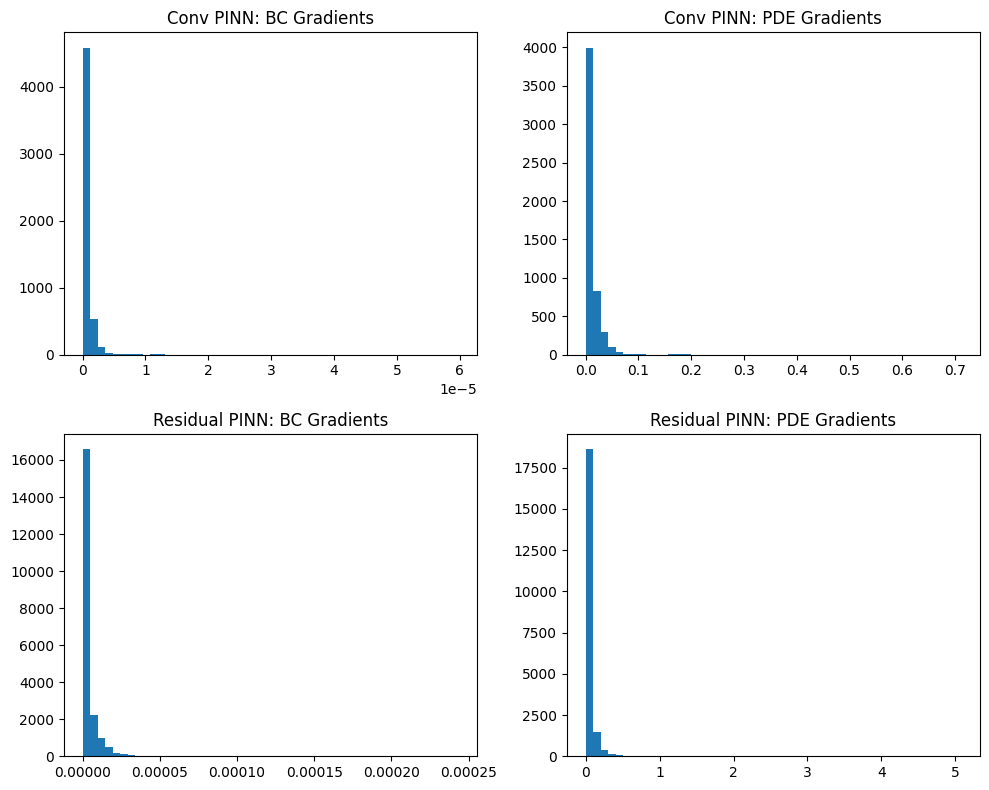

In [ ]:
# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes[0,0].hist(grad_bc_conv, bins=50)
axes[0,0].set_title("Conv PINN: BC Gradients")
axes[0,1].hist(grad_pde_conv, bins=50)
axes[0,1].set_title("Conv PINN: PDE Gradients")
axes[1,0].hist(grad_bc_res, bins=50)
axes[1,0].set_title("Residual PINN: BC Gradients")
axes[1,1].hist(grad_pde_res, bins=50)
axes[1,1].set_title("Residual PINN: PDE Gradients")
plt.tight_layout()
plt.xlabel('Gradient Magnitude')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Training function that separates main vs shortcut gradients
def train_and_compare(model, epochs=2000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    final = {}
    for epoch in trange(epochs, desc="Training"):
        xf, xb, ub = sampler(1000, 200)
        pred_b = model(xb)
        loss_bc = 30000 * mse(pred_b, ub)
        loss_pde = mse(helmholtz_residual(model, xf), torch.zeros_like(xf[:,0:1]))

        # Compute gradients for BC loss
        optimizer.zero_grad()
        loss_bc.backward(retain_graph=True)
        grads_bc_main, grads_bc_skip = [], []
        for block in model.blocks:
            grads_bc_main.extend([block.linear1.weight.grad.abs().mean().item(),
                                  block.linear2.weight.grad.abs().mean().item()])
            grads_bc_skip.append(block.shortcut.weight.grad.abs().mean().item())

        # Compute gradients for PDE loss
        optimizer.zero_grad()
        loss_pde.backward(retain_graph=True)
        grads_pde_main, grads_pde_skip = [], []
        for block in model.blocks:
            grads_pde_main.extend([block.linear1.weight.grad.abs().mean().item(),
                                   block.linear2.weight.grad.abs().mean().item()])
            grads_pde_skip.append(block.shortcut.weight.grad.abs().mean().item())

        # Record final epoch values
        if epoch == epochs - 1:
            final = {
                "bc_main": grads_bc_main,
                "bc_skip": grads_bc_skip,
                "pde_main": grads_pde_main,
                "pde_skip": grads_pde_skip
            }

        # Parameter update
        optimizer.zero_grad()
        (loss_bc + loss_pde).backward()
        optimizer.step()

    return final

Training: 100%|██████████| 2000/2000 [01:11<00:00, 28.01it/s]


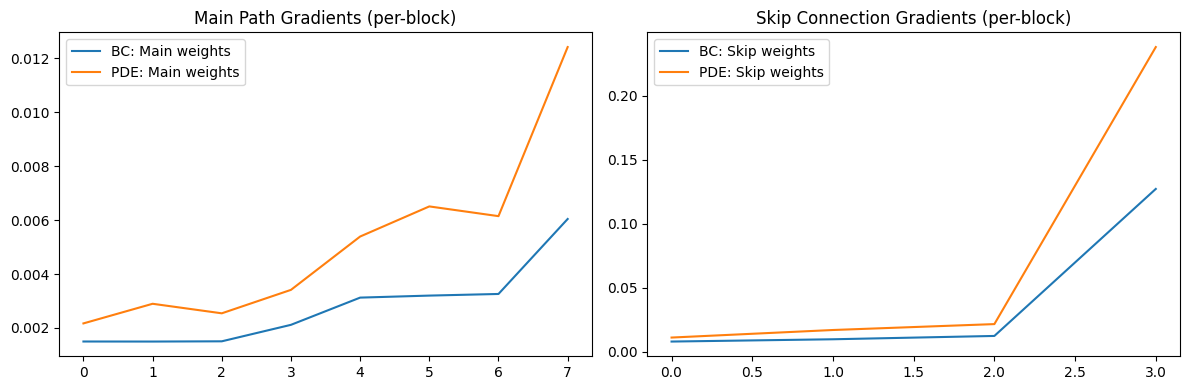

In [27]:
# Run experiment
model = ResidualPINN(input_dim=2, hidden_dim=50, num_blocks=4)
results = train_and_compare(model)

# Plot comparison
num_blocks = len(results["bc_skip"])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boundary vs PDE for main path
axes[0].plot(results["bc_main"], label="BC: Main weights")
axes[0].plot(results["pde_main"], label="PDE: Main weights")
axes[0].set_title("Main Path Gradients (per-block)")
axes[0].legend()

# Boundary vs PDE for skip connections
axes[1].plot(results["bc_skip"], label="BC: Skip weights")
axes[1].plot(results["pde_skip"], label="PDE: Skip weights")
axes[1].set_title("Skip Connection Gradients (per-block)")
axes[1].legend()

plt.tight_layout()
plt.show()

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Training: 100%|██████████| 2000/2000 [00:46<00:00, 42.92it/s]


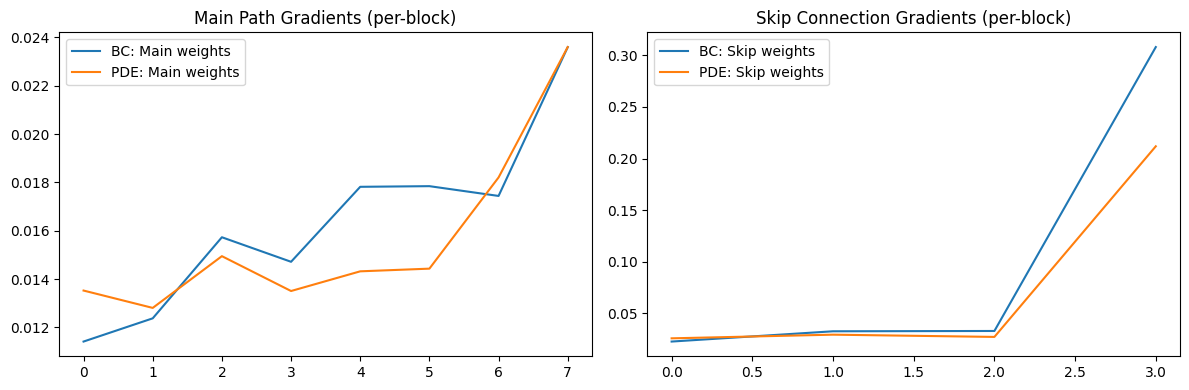

In [20]:
# Run experiment
model_1 = ResidualPINN(input_dim=2, hidden_dim=50, num_blocks=4)
results_1 = train_and_compare(model_1)

# Plot comparison
num_blocks = len(results_1["bc_skip"])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boundary vs PDE for main path
axes[0].plot(results_1["bc_main"], label="BC: Main weights")
axes[0].plot(results_1["pde_main"], label="PDE: Main weights")
axes[0].set_title("Main Path Gradients (per-block)")
axes[0].legend()

# Boundary vs PDE for skip connections
axes[1].plot(results_1["bc_skip"], label="BC: Skip weights")
axes[1].plot(results_1["pde_skip"], label="PDE: Skip weights")
axes[1].set_title("Skip Connection Gradients (per-block)")
axes[1].legend()

plt.tight_layout()
plt.show()

Training: 100%|██████████| 2000/2000 [03:21<00:00,  9.92it/s]


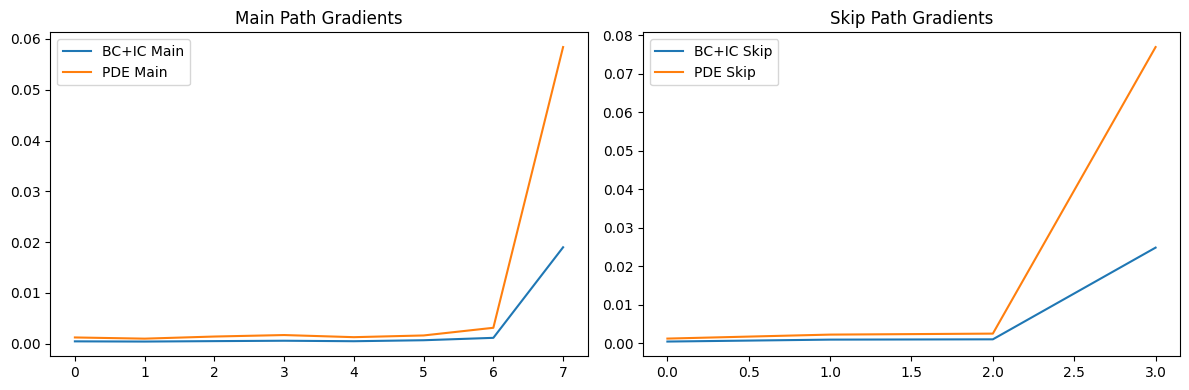

In [21]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from tqdm import trange

# 1D Burgers PDE PINN: u_t + u u_x = ν u_xx

# Conventional MLP PINN
class ConventionalPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        mods = []
        for i in range(len(layers)-1):
            mods.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                mods.append(nn.Tanh())
        self.model = nn.Sequential(*mods)
    def forward(self, x):
        return self.model(x)

# Residual PINN
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.act = nn.Tanh()
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, out_dim)
        self.skip = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.l3(self.act(self.l2(self.act(self.l1(x))))) + self.skip(x)

class ResidualPINN(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_blocks):
        super().__init__()
        blocks = [ResidualBlock(in_dim, hidden_dim, hidden_dim)]
        for _ in range(num_blocks-2):
            blocks.append(ResidualBlock(hidden_dim, hidden_dim, hidden_dim))
        blocks.append(ResidualBlock(hidden_dim, hidden_dim, 1))
        self.blocks = nn.ModuleList(blocks)
    def forward(self, x):
        for b in self.blocks:
            x = b(x)
        return x

# Burgers residual
def burgers_residual(model, x, nu=0.01/torch.pi):
    x.requires_grad_(True)
    u = model(x)
    grads = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,1:2]
    u_x = grads[:,0:1]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0][:,0:1]
    return u_t + u*u_x - nu*u_xx

# Sampling: interior, boundary, initial
def sampler(n_int, n_bnd, n_init):
    # interior points in (x,t) ∈ [-1,1]×[0,1]
    xt_int = torch.rand(n_int,2)
    xt_int[:,0] = xt_int[:,0]*2 - 1
    # boundary: x=-1 or 1, t∈[0,1]
    tb = torch.rand(n_bnd,1)
    xb = torch.cat([torch.full((n_bnd//2,1),-1), tb[:n_bnd//2]], dim=1)
    xb2 = torch.cat([torch.full((n_bnd - n_bnd//2,1), 1), tb[n_bnd//2:]], dim=1)
    xb = torch.cat([xb, xb2], dim=0)
    ub = torch.zeros_like(xb[:,0:1])
    # initial: t=0, x∈[-1,1]
    xi = torch.rand(n_init,1)*2 - 1
    ti = torch.zeros_like(xi)
    xi_ti = torch.cat([xi, ti], dim=1)
    ui = -torch.sin(torch.pi*xi)
    return xt_int, xb, ub, xi_ti, ui

mse = nn.MSELoss()

# Train & compare gradients
def train_and_compare(model, epochs=2000, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    final = {}
    for ep in trange(epochs, desc="Training"):
        xt, xb, ub, xi, ui = sampler(10000, 200, 200)
        # losses
        loss_bnd = mse(model(xb), ub)
        loss_ini = mse(model(xi), ui)
        loss_pde = mse(burgers_residual(model, xt), torch.zeros_like(xt[:,0:1]))

        # BC+IC combined
        loss_bc = loss_bnd + loss_ini

        # compute grads
        opt.zero_grad()
        loss_bc.backward(retain_graph=True)
        bc_main, bc_skip = [], []
        for blk in model.blocks:
            bc_main.append(blk.l1.weight.grad.abs().mean().item())
            bc_main.append(blk.l2.weight.grad.abs().mean().item())
            bc_skip.append(blk.skip.weight.grad.abs().mean().item())

        opt.zero_grad()
        loss_pde.backward(retain_graph=True)
        pde_main, pde_skip = [], []
        for blk in model.blocks:
            pde_main.append(blk.l1.weight.grad.abs().mean().item())
            pde_main.append(blk.l2.weight.grad.abs().mean().item())
            pde_skip.append(blk.skip.weight.grad.abs().mean().item())

        if ep == epochs - 1:
            final = {
                "bc_main": bc_main, "bc_skip": bc_skip,
                "pde_main": pde_main, "pde_skip": pde_skip
            }

        # update
        opt.zero_grad()
        (loss_bc + loss_pde).backward()
        opt.step()

    return final

# Run experiment
model = ResidualPINN(in_dim=2, hidden_dim=50, num_blocks=4)
res = train_and_compare(model)

# Plot
blocks = len(res["bc_skip"])
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(res["bc_main"], label="BC+IC Main"); axs[0].plot(res["pde_main"], label="PDE Main")
axs[0].set_title("Main Path Gradients"); axs[0].legend()
axs[1].plot(res["bc_skip"], label="BC+IC Skip"); axs[1].plot(res["pde_skip"], label="PDE Skip")
axs[1].set_title("Skip Path Gradients"); axs[1].legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from tqdm import trange

# 2D Poisson Equation PINN
# ∇²u(x,y) = f(x,y),  (x,y) ∈ [0,1]²
# with u(x,y) = sin(πx) sin(πy) on ∂Ω

# 1) Model architectures

class ConventionalPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        mods = []
        for i in range(len(layers)-1):
            mods.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                mods.append(nn.Tanh())
        self.net = nn.Sequential(*mods)

    def forward(self, x):
        return self.net(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        self.skip = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.fc3(self.act(self.fc2(self.act(self.fc1(x))))) + self.skip(x)

class ResidualPINN(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_blocks):
        super().__init__()
        blocks = [ResidualBlock(in_dim, hidden_dim, hidden_dim)]
        for _ in range(num_blocks-2):
            blocks.append(ResidualBlock(hidden_dim, hidden_dim, hidden_dim))
        blocks.append(ResidualBlock(hidden_dim, hidden_dim, 1))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for b in self.blocks:
            x = b(x)
        return x

# 2) PDE residual for Poisson: ∂²u/∂x² + ∂²u/∂y² = f(x,y)
def poisson_residual(model, x):
    x.requires_grad_(True)
    u = model(x)
    grads = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, x, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    # Manufactured solution: u = sin(pi x) sin(pi y)
    f = -2 * (torch.pi**2) * torch.sin(torch.pi * x[:, 0:1]) * torch.sin(torch.pi * x[:, 1:2])
    return u_xx + u_yy - f

# 3) Data sampler
def sampler(n_int, n_bnd):
    # Interior collocation points in (0,1)^2
    x_int = torch.rand(n_int, 2)
    # Boundary points: equally on 4 sides
    n_side = n_bnd // 4
    x0 = torch.cat([torch.zeros(n_side,1), torch.rand(n_side,1)], dim=1)
    x1 = torch.cat([torch.ones(n_side,1),  torch.rand(n_side,1)], dim=1)
    y0 = torch.cat([torch.rand(n_side,1),  torch.zeros(n_side,1)], dim=1)
    y1 = torch.cat([torch.rand(n_side,1),  torch.ones(n_side,1)], dim=1)
    x_bnd = torch.cat([x0, x1, y0, y1], dim=0)
    # Exact boundary values
    u_bnd = torch.sin(torch.pi * x_bnd[:,0:1]) * torch.sin(torch.pi * x_bnd[:,1:2])
    return x_int, x_bnd, u_bnd

# 4) Loss function
mse = nn.MSELoss()
def loss_fn(model, x_int, x_bnd, u_bnd):
    loss_pde = mse(poisson_residual(model, x_int), torch.zeros_like(x_int[:,0:1]))
    loss_bc  = mse(model(x_bnd), u_bnd)
    return loss_bc, loss_pde

In [29]:
# 5) Training with gradient monitoring
def train_and_monitor_poisson(model, epochs=2000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    final = {}
    for epoch in trange(epochs, desc="Training"):
        x_int, x_bnd, u_bnd = sampler(5000, 400)
        loss_bc, loss_pde = loss_fn(model, x_int, x_bnd, u_bnd)

        # Monitor BC gradients
        optimizer.zero_grad()
        loss_bc.backward(retain_graph=True)
        bc_main, bc_skip = [], []
        for blk in model.blocks:
            bc_main.append(blk.fc1.weight.grad.abs().mean().item())
            bc_main.append(blk.fc2.weight.grad.abs().mean().item())
            bc_skip.append(blk.skip.weight.grad.abs().mean().item())

        # Monitor PDE gradients
        optimizer.zero_grad()
        loss_pde.backward(retain_graph=True)
        pde_main, pde_skip = [], []
        for blk in model.blocks:
            pde_main.append(blk.fc1.weight.grad.abs().mean().item())
            pde_main.append(blk.fc2.weight.grad.abs().mean().item())
            pde_skip.append(blk.skip.weight.grad.abs().mean().item())

        # Save final epoch values
        if epoch == epochs - 1:
            final = {
                "bc_main": bc_main,
                "bc_skip": bc_skip,
                "pde_main": pde_main,
                "pde_skip": pde_skip,
            }

        # Parameter update
        optimizer.zero_grad()
        (loss_bc + loss_pde).backward()
        optimizer.step()

    return final

# 6) Run experiment and plot
res_pinn = ResidualPINN(in_dim=2, hidden_dim=50, num_blocks=4)
results = train_and_monitor_poisson(res_pinn, epochs=2000, lr=1e-3)

# Plotting
num_main = len(results["bc_main"])
num_skip = len(results["bc_skip"])
layers_main = list(range(num_main))
layers_skip = list(range(num_skip))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Main path gradients
axs[0].plot(layers_main, results["bc_main"], 'o-', label="BC main")
axs[0].plot(layers_main, results["pde_main"], 'o-', label="PDE main")
axs[0].set_title("Main Path Gradient Magnitudes")
axs[0].set_xlabel("Layer Index")
axs[0].set_ylabel("Mean |gradient|")
axs[0].legend()

# Skip connection gradients
axs[1].plot(layers_skip, results["bc_skip"], 'o-', label="BC skip")
axs[1].plot(layers_skip, results["pde_skip"], 'o-', label="PDE skip")
axs[1].set_title("Skip Connection Gradient Magnitudes")
axs[1].set_xlabel("Block Index")
axs[1].set_ylabel("Mean |gradient|")
axs[1].legend()

plt.tight_layout()
plt.show()


Training:   0%|          | 0/2000 [00:00<?, ?it/s]


AttributeError: 'ResidualBlock' object has no attribute 'fc1'